In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def import_sys():
    import sys
    sys.path.append('..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name


In [2]:
import pandas as pd
from tqdm import tqdm

from overrides import overrides

from errudite.io import DatasetReader
from errudite.utils import normalize_file_path, accuracy_score
from errudite.targets.instance import Instance
from errudite.targets.target import Target
from errudite.targets.label import Label, PredefinedLabel

In [3]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from typing import List, Dict
import sys
sys.path.append('..')
from errudite.predictors.predictor import Predictor
from errudite.targets.label import Label, PredefinedLabel

class Predictor_FLAN_T5(Predictor):
    def __init__(self, name: str, 
    model_path: str=None,
    model_online_path: str=None,
    description: str='',
    model_type: str=None) -> None:
        model = None
        Predictor.__init__(self, name, description, model, ['accuracy', 'accuracy_PE', 'accuracy_KE', 'accuracy_LCE'])
        
    def predict_essay(self, essay : str) -> Dict[str,str]:
        # Load data into pandas DataFrame
        data_df = pd.read_excel("StudentEssays.xlsx")

        # Initialize T5 tokenizer and model
        tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
        model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

        # Move the model to the CUDA device if available
        if torch.cuda.is_available():
            model.to("cuda")

        # Define a list of concepts to predict
        concepts_to_predict = ["potential energy", "kinetic energy", "Law of Conservation of Energy"]

        # Define possible outcome labels
        outcome_labels = ["Acceptable", "Unacceptable", "Insufficient", "Not Found"]

        # Create a list to store predictions as dictionaries
        predictions_list = []

        text = essay  # Assuming the text content is in column 'Essay'

        # Initialize predictions dictionary for this row
        predictions = {}

        # Iterate through each concept to predict
        for concept in concepts_to_predict:
            # Define a template for classification
            template = f"According to the following essay, is the student's definition of {concept} Acceptable, Unacceptable, Insufficient, or Not Found? Only use one of these labels for outputs\n{text}"
            # Prepare the input by replacing placeholders
            formatted_input = template
            # Tokenize and classify the text
            input_ids = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True).input_ids.to("cuda" if torch.cuda.is_available() else "cpu")
            outputs = model.generate(input_ids, max_length=128)
            decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)  # Remove special tokens

            # Store the prediction in the dictionary
            predictions[concept] = next((label for label in outcome_labels if label.lower() in decoded_output.lower()), "Unknown")

            if predictions[concept] == "Unknown":
              print(len(decoded_output))
              with open('output.txt', 'w') as f:
                f.write(decoded_output)

        return predictions

INFO:pytorch_pretrained_bert.modeling:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_bert:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:pytorch_transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>
INFO:allennlp.common.registrable:instantiating registered subclass relu of <class 'allennlp.nn.activations.Activation'>


In [4]:
@DatasetReader.register("STE")
class STEReader(DatasetReader):
    def __init__(self, cache_folder_path: str=None) -> None:
        super().__init__(cache_folder_path)
        # overwrite the primary evaluation method and metric name
        Label.set_task_evaluator(accuracy_score, 'accuracy')
        
    @overrides
    def _read(self, file_path: str, lazy: bool, sample_size: int):
        """
        Returns a list containing all the instances in the specified dataset.
 
        Parameters
        ----------
        file_path : str
            The path of the input data file.
        lazy : bool, optional
            If ``lazy==True``, only run the tokenization, does not compute the linguistic
            features like POS, NER. By default False
        sample_size : int, optional
            If sample size is set, only load this many of instances, by default None
        
        Returns
        -------
        List[Instance]
            The instance list.
        """
        instances = []
        essays = []
        logger.info("Reading instances from lines in file at: %s", file_path)
        df = pd.read_excel(normalize_file_path(file_path), sep='\t')
        for idx, row in tqdm(df.iterrows()):
            if lazy:
                essays.append(row['Essay'])
            else:
                instance = self._text_to_instance(f'q:{idx}', row)
                if instance is not None:
                    instances.append(instance)
                if sample_size and idx > sample_size:
                    break
        if lazy:
            return { "Essays": essays }
        else:
            return instances
    
    @overrides
    def _text_to_instance(self, id: str, row) -> Instance:
        # The function that transfers raw text to instance.
        essay = Target(qid=row['Essay_ID'], text=row['Essay'], vid=0, metas={'type': 'essays'})        # label
        groundtruth_PE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['PE'], 
            vid=0, 
        )
        groundtruth_KE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['KE'], 
            vid=0, 
        )
        groundtruth_LCE = PredefinedLabel(
            model='groundtruth', 
            qid=row['Essay_ID'], 
            text=row['LCE'], 
            vid=0, 
        )
        return self.create_instance(row['Essay_ID'], 
            essay=essay, 
            groundtruth_PE=groundtruth_PE,
            groundtruth_KE=groundtruth_KE,
            groundtruth_LCE=groundtruth_LCE)

In [5]:
from errudite.io import DatasetReader

cache_folder_path = "./ste_caches"
reader = DatasetReader.by_name("STE")(cache_folder_path=cache_folder_path)

INFO:errudite.utils.file_utils:Errudite cache folder selected: ./ste_caches


In [6]:
# read the raw data!
instances = reader.read(
    # The path of the input data file. We are using the first 100 rows from the SNLI dev set.
    file_path='StudentEssays.xlsx', 
    # If sample size is set, only load this many of instances, by default None.
    sample_size=76)

INFO:errudite.io.dataset_reader:Reading instances from lines in file at: StudentEssays.xlsx
INFO:__main__:Reading instances from lines in file at: StudentEssays.xlsx
76it [00:02, 30.31it/s]


In [7]:
from typing import List, Dict
import sys
sys.path.append('..')
from errudite.predictors.predictor import Predictor
from errudite.targets.label import Label, PredefinedLabel

In [8]:
@Predictor.register("STE_FLAN_T5")
class PredictorSTE(Predictor_FLAN_T5):
    def __init__(self, name: str, 
        model_path: str=None,
        model_online_path: str=None,
        description: str='') -> None:
        Predictor_FLAN_T5.__init__(self, name, model_path, model_online_path, description)
        import sys
        sys.path.append('..')
        from errudite.utils.evaluator import accuracy_score
        # Second, from the metrics above, pick one that's primary, and it will be used 
        # to compute `is_incorrect()` in any label target object: primary metric < 1.
        Label.set_task_evaluator(
            # the evaluation function that accepts pred and groundtruths, 
            # and return a dict of metrics: { metric_name: metric_score }. 
            # This is saved as Label.task_evaluation_func.
            task_evaluation_func=accuracy_score, 
            # The primary task metric name, ideally a key of task_evaluation_func ‘s return.
            task_primary_metric='accuracy')

    # the raw prediction function, returning the output of the model in a json format.
    def predict(self, essay: str) -> Dict[str, str]:
        predicted = self.predict_essay(essay)
        return predicted

    @classmethod
    # the class method that takes `Target` inputs, and output a `Label` object.
    def model_predict(cls, 
        predictor: Predictor, 
        essay: Target, 
        groundtruth_PE: Label, groundtruth_KE: Label, groundtruth_LCE: Label) -> 'Label':
        answer = None
        if not predictor:
            return answer
        predicted = predictor.predict(essay.get_text())
        if not predicted:
            return None
        answer_PE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['potential energy'], 
            vid=max([essay.vid]))
        answer_KE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['kinetic energy'], 
            vid=max([essay.vid]))
        answer_LCE = PredefinedLabel(
            model=predictor.name, 
            qid=essay.qid,
            text=predicted['Law of Conservation of Energy'], 
            vid=max([essay.vid]))
        answer_PE.compute_perform(groundtruths=groundtruth_PE)
        answer_KE.compute_perform(groundtruths=groundtruth_KE)
        answer_LCE.compute_perform(groundtruths=groundtruth_LCE)
        return answer_PE, answer_KE, answer_LCE



In [9]:
from errudite.predictors import Predictor
model_path = "FLAN_T5_Essay"
predictor = Predictor.by_name("STE_FLAN_T5")(
    name ='FLAN_T5', 
    description='Prediction created by FLAN_T5')

In [10]:
import traceback
from typing import Union, List
from spacy.tokens import Doc, Span, Token
def import_sys():
    import sys
    sys.path.append('..')
import_sys()
from errudite.utils.helpers import convert_doc
from errudite.utils.check import DSLValueError
import logging
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

In [13]:
from tqdm import tqdm 
logger.info("Running predictions....") 
for instance in tqdm(instances):
    prediction_PE, prediction_KE, prediction_LCE = Predictor.by_name("STE_FLAN_T5").model_predict(
        predictor, 
        essay = instance.essay,
        groundtruth_PE = instance.groundtruth_PE, groundtruth_KE = instance.groundtruth_KE, groundtruth_LCE = instance.groundtruth_LCE)
    # set the prediction
    instance.set_entries(prediction_PE = prediction_PE, prediction_KE = prediction_KE, prediction_LCE = prediction_LCE)

INFO:__main__:Running predictions....
100%|██████████| 76/76 [13:35<00:00,  9.75s/it]


In [13]:
# print(instances[2].get_entry('essay'), "\n")
# instances[2].show_instance()

In [14]:
# ---------
# Build the instance store hash
from errudite.targets.instance import Instance
instance_hash, instance_hash_rewritten, qid_hash = Instance.build_instance_hashes(instances)

## Group - Length of the Essay

In [11]:
from errudite.builts import Group
from errudite.builts import Attribute
group_length_10 = Group.create(
    # The name of the attribute
    name="length",
    # the description of the attribute
    description="length greater than 10",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="length(essay) > 10",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(length):[ArgOp:essay]+[], 10.0]
INFO:errudite.builts.group:Created group: length


In [12]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group_length_10.get_instances(),
    # this will automatically call the default model we got
    model=None
)

ZeroDivisionError: division by zero

In [57]:
from errudite.builts import Group
from errudite.builts import Attribute
group_length_200 = Group.create(
    # The name of the attribute
    name="length",
    # the description of the attribute
    description="length greater than 200",
    # All the previously created attributes and groups 
    # can be used and queried, as long as we serve the 
    # stored attributes and groups as part of the inputs.
    cmd="length(essay) > 200",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[FuncOp(length):[ArgOp:essay]+[], 200.0]
INFO:errudite.builts.group:Created group: length


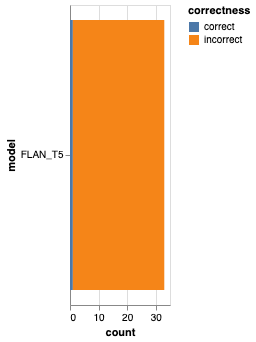

In [58]:
group_length_200.visualize_models(models=["FLAN_T5"])

In [59]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=group_length_200.get_instances(),
    # this will automatically call the default model we got
    model=None
)

{'counts': {'correct': 1, 'incorrect': 32},
 'stats': {'coverage': 0.4342105263157895,
  'error_coverage': 0.4383561643835616,
  'local_error_rate': 0.9696969696969697,
  'global_error_rate': 0.42105263157894735}}

## Group - Quantitative Value

In [26]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def contains_quantity(docs: Union['Target', Span]) -> bool:
    """
    Detect the presence of quantity entities in the essay.
    quantity entity: measurements or counts.
    """
    # Use the linguistic function to extract entity types
    entities = linguistic(docs, label='ent_type')
    # print(entities)
    # print(docs)
    contains='QUANTITY' in entities
    # Check if 'bottom' or 'top' is present in the extracted entity types
    #print(contains)
    return contains


In [27]:
from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="quantity_entities",
    description="Presence of quantity entities in the essay",
    cmd="contains_quantity(essay)"
)

# Create a group that checks for the presence of location entities
quantity_group = Group.create(
    name="quantity",
    description="quantity entity detected",
    cmd="attr:quantity_entities == TRUE",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)
quantity_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_quantity):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: quantity_entities
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):quantity_entities, True]
INFO:errudite.builts.group:Created group: quantity


<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class '

[Group](quantity): 
	CMD	: attr:quantity_entities == TRUE
	COUNT	: 49

In [28]:
count_group_list = []

for key in quantity_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.0, 'accuracy_PE': 0.40816326530612246, 'accuracy_KE': 0.3469387755102041, 'accuracy_LCE': 0.30612244897959184}}


In [31]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def contains_ordinal(docs: Union['Target', Span]) -> bool:
    """
    Detect the presence of ordinal entities in the essay.
    ordinal entity: measurements or counts.
    """
    # Use the linguistic function to extract entity types
    entities = linguistic(docs, label='ent_type')
    # print(entities)
    # print(docs)
    contains='ORDINAL' in entities
    # Check if 'bottom' or 'top' is present in the extracted entity types
    #print(contains)
    return contains


In [32]:
from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="ordinal_entities",
    description="Presence of ordinal entities in the essay",
    cmd="contains_ordinal(essay)"
)

# Create a group that checks for the presence of ordinal entities
ordinal_group = Group.create(
    name="ordinal",
    description="ordinal entity detected",
    cmd="attr:ordinal_entities == TRUE",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)
quantity_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_ordinal):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: ordinal_entities
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):ordinal_entities, True]
INFO:errudite.builts.group:Created group: ordinal


<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class 'spacy.tokens.doc.Doc'>
<class '

[Group](quantity): 
	CMD	: attr:quantity_entities == TRUE
	COUNT	: 49

In [33]:
count_group_list = []

for key in ordinal_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.0, 'accuracy_PE': 0.35714285714285715, 'accuracy_KE': 0.2857142857142857, 'accuracy_LCE': 0.2857142857142857}}


In [42]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import linguistic

@PrimFunc.register()
def contains_cardinal(docs: Union['Target', Span]) -> bool:
    """
    Detect the presence of quantity entities in the essay.
    quantity entity: measurements or counts.
    """
    # Use the linguistic function to extract entity types
    entities = linguistic(docs, label='ent_type')
    print(entities)
    #print(docs)
    contains='CARDINAL' in entities
    # Check if 'bottom' or 'top' is present in the extracted entity types
    #print(contains)
    return contains


In [43]:
from errudite.builts import Attribute, Group

# Create an attribute based on the location function
attr = Attribute.create(
    name="cardinal_entities",
    description="Presence of cardinal entities in the essay",
    cmd="contains_cardinal(essay)"
)

# Create a group that checks for the presence of location entities
cardinal_group = Group.create(
    name="cardinal",
    description="cardinal entity detected",
    cmd="attr:cardinal_entities == TRUE",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)
quantity_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_cardinal):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: cardinal_entities
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):cardinal_entities, True]
INFO:errudite.builts.group:Created group: cardinal


<class 'spacy.tokens.doc.Doc'>
['', '', '', '', '', '', '', '', 'QUANTITY', 'QUANTITY', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'GPE', '', '', '', '', 'ORG', '', '', '', '', '', '', '', '', '', 'QUANTITY', 'QUANTITY', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'LAW', 'LAW', 'LAW', 'LAW', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'ORG', 'ORG', 'ORG', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'CARDINAL', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'QUANTITY', 'QUANTITY', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

[Group](quantity): 
	CMD	: attr:quantity_entities == TRUE
	COUNT	: 49

In [37]:
count_group_list = []

for key in quantity_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.0, 'accuracy_PE': 0.40816326530612246, 'accuracy_KE': 0.3469387755102041, 'accuracy_LCE': 0.30612244897959184}}


## Group - Number of Adjectives

In [21]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_adjectives(target: 'Target') -> int:
    """
    Count the number of adjectives in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        adjectives = [token for token in doc if token.pos_ == "ADJ"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex




In [26]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_adjectives_in_essay",
    description="Number of adjectives among essay targets",
    cmd="num_adjectives(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
adj_count_group = Group.create(
    name="adjective_count_group",
    description="Group for counting adjectives in the essay",
    cmd="attr:num_adjectives_in_essay > 30",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
adj_count_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_adjectives):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: num_adjectives_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[[BuildBlockOp](attr):num_adjectives_in_essay, 30.0]
INFO:errudite.builts.group:Created group: adjective_count_group


[Group](adjective_count_group): 
	CMD	: attr:num_adjectives_in_essay > 30
	COUNT	: 3

In [27]:
count_group_list = []
for key in adj_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.0, 'accuracy_PE': 0.3333333333333333, 'accuracy_KE': 0.0, 'accuracy_LCE': 0.3333333333333333}}


## Group - Number of Verbs

In [28]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_verbs(target: 'Target') -> int:
    """
    Count the number of verbs in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        adjectives = [token for token in doc if token.pos_ == "VERB"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex




In [35]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_verbs_in_essay",
    description="Number of verbs among essay targets",
    cmd="num_verbs(essay)"
)


# Create a group to check if there are more than 20 verbs in the essay
verb_count_group = Group.create(
    name="verb_count_group",
    description="Group for counting verbs in the essay",
    cmd="attr:num_verbs_in_essay > 40",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
verb_count_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_verbs):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: num_verbs_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[[BuildBlockOp](attr):num_verbs_in_essay, 40.0]
INFO:errudite.builts.group:Created group: verb_count_group


[Group](verb_count_group): 
	CMD	: attr:num_verbs_in_essay > 40
	COUNT	: 20

In [36]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.05, 'accuracy_PE': 0.5, 'accuracy_KE': 0.5, 'accuracy_LCE': 0.25}}


In [77]:
# # some general stats on groups
# Group.eval_stats(
#     filtered_instances=adj_count_group.get_instances(),
#     # this will automatically call the default model we got
#     model=None
# )

{'counts': {'correct': 3, 'incorrect': 73},
 'stats': {'coverage': 1.0,
  'error_coverage': 1.0,
  'local_error_rate': 0.9605263157894737,
  'global_error_rate': 0.9605263157894737}}

## Group - Number of Nouns

In [43]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def num_verbs(target: 'Target') -> int:
    """
    Count the number of verbs in a given target.
    """
    try:
        # Access the tokens associated with the Target
        #print(STRING(target))
        #tokens = STRING(target).tokens
        doc = nlp(STRING(target))
        adjectives = [token for token in doc if token.pos_ == "NOUN"]
        return len(adjectives)
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex




In [53]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="num_verbs_in_essay",
    description="Number of verbs among essay targets",
    cmd="num_verbs(essay)"
)


# Create a group to check if there are more than 20 verbs in the essay
verb_count_group = Group.create(
    name="verb_count_group",
    description="Group for counting verbs in the essay",
    cmd="attr:num_verbs_in_essay > 20",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
verb_count_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(num_verbs):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: num_verbs_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](>):[[BuildBlockOp](attr):num_verbs_in_essay, 20.0]
INFO:errudite.builts.group:Created group: verb_count_group


[Group](verb_count_group): 
	CMD	: attr:num_verbs_in_essay > 20
	COUNT	: 75

In [54]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

{'predictor': 'FLAN_T5', 'perform': {'accuracy': 0.04, 'accuracy_PE': 0.5466666666666666, 'accuracy_KE': 0.4, 'accuracy_LCE': 0.26666666666666666}}


## Group - Contains Location Entity

In [ ]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def contains_loc(target: 'Target') -> int:
    """
    Detect the presence of location entities ('bottom' or 'top') in the essay.
    """
    try:
        # Access the tokens associated with the Target
        target_str=STRING(target)
        #tokens = STRING(target).tokens
        if "bottom" in target_str or "top" in target_str:
            return True
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex



In [ ]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="contains_loc_in_essay",
    description="Number of locations among essay targets",
    cmd="contains_loc(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
contains_loc_group = Group.create(
    name="adjective_count_group",
    description="Group for counting locations in the essay",
    cmd="attr:contains_loc_in_essay==TRUE ",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
contains_loc_group

In [ ]:
# some general stats on groups
Group.eval_stats(
    filtered_instances=contains_loc_group.get_instances(),
    # this will automatically call the default model we got
    model=None
)

In [ ]:
contains_loc_group.visualize_models(models=["FLAN_T5"])

In [15]:
from errudite.build_blocks import PrimFunc
from errudite.build_blocks.prim_funcs.linguistic import STRING
import spacy
nlp = spacy.load("en_core_web_sm")


@PrimFunc.register()
def contains_loc(target: 'Target') -> int:
    """
    Detect the presence of location entities ('bottom' or 'top') in the essay.
    """
    try:
        # Access the tokens associated with the Target
        answer_type(target)
        #target_str=STRING(target)
        #tokens = STRING(target).tokens
        #if "bottom" in target_str or "top" in target_str:
         #   return True
    except Exception as e:
        ex = Exception(f"Unknown exception from [num_adjectives]: {e}")
        raise ex



In [16]:
from errudite.builts import Attribute, Group

# Assuming you have already defined the PrimFunc num_adjectives

# Create an attribute that counts the adjectives among essay targets
attr = Attribute.create(
    name="contains_loc_in_essay",
    description="Number of adjectives among essay targets",
    cmd="contains_loc(essay)"
)


# Create a group to check if there are more than 5 adjectives in the essay
contains_loc_group = Group.create(
    name="adjective_count_group",
    description="Group for counting adjectives in the essay",
    cmd="attr:contains_loc_in_essay==TRUE ",
    attr_hash=Attribute.store_hash(),
    group_hash=Group.store_hash()
)

# You can now use the 'group' to check if there are more than 5 adjectives in your essay targets.
contains_loc_group

INFO:errudite.build_blocks.wrapper:Parsed: FuncOp(contains_loc):[ArgOp:essay]+[]
INFO:errudite.builts.attribute:Created attr: contains_loc_in_essay
INFO:errudite.build_blocks.wrapper:Parsed: [BinOp](==):[[BuildBlockOp](attr):contains_loc_in_essay, True]
INFO:errudite.builts.group:Created group: adjective_count_group


[Target] [InstanceKey(qid='L24-RCFinal proposal, L3b8-23_RCFinal proposal, & L3b8-08_RCFinal proposal', vid=0)]
The initial hill height that I choose was 45 meters because we wanted it to be the tallest height as possible so it would have the most potential energy. I choose this height because it will have more potential energy to go all over the rollercoaster. During the initial drop, most of the js of PE will be transforming into K.E.E with the loss of heat. 

I choose 25 meters hill height because the car would have less kinetic energy when going down hill into the stopping point. We could not make the hill taller than the initial drop because of the Law of Conservation of energy, which says energy cannot be created or destroyed. The hill will be good because they are still using energy from the initial drop. The final part of the Pacific Coaster is the stopping portion, ending in water. Potential energy was tranformed into heat energy, instead of K.E.The car will also have a lot mo

[Group](adjective_count_group): 
	CMD	: attr:contains_loc_in_essay==TRUE 
	COUNT	: 57

In [17]:
count_group_list = []
for key in verb_count_group.get_instances():
    count_group_list.append(Instance.get(key))

predictor.evaluate_performance(count_group_list)
print({"predictor": predictor.name, "perform": predictor.perform })

NameError: name 'verb_count_group' is not defined